In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
# from kneebow.rotor import Rotor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import os
import re

## Funciones auxiliares

In [2]:
#We calculate or k-distance for determinate our eps value.
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:,1:].reshape(-1)

#We get the eps exact value using kneebow, this function allows
#us to find the elbow of a curve by rotating the curve and taking
#the minimum value.
def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)],1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx]

## carga de datos 

In [3]:
file_path="../data/interim/estadisticas_edificios.csv"

In [4]:
data = pd.read_csv(file_path)
data.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027


In [5]:
data.columns

Index(['type_building', 'var1_mean', 'var1_std_dev', 'var2_mean',
       'var2_std_dev'],
      dtype='object')

In [6]:
# Obtener un resumen estadístico y mostrar la información general del conjunto de datos
summary = data.describe()
summary

,var1_mean,var1_std_dev,var2_mean,var2_std_dev
count,80.000000,80.000000,80.000000,80.000000
mean,41.707922,46.497957,44.721192,24.728418
std,120.139988,72.987056,61.317985,31.327799
min,0.000000,1.201939,1.011600,1.278151
25%,0.000000,6.376172,11.303727,4.654335
50%,0.000000,10.853409,22.338642,13.133033
75%,7.759010,36.654344,44.437106,27.107491
max,511.932392,264.972046,199.362908,116.539481


In [7]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_building  80 non-null     object 
 1   var1_mean      80 non-null     float64
 2   var1_std_dev   80 non-null     float64
 3   var2_mean      80 non-null     float64
 4   var2_std_dev   80 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.3+ KB


In [8]:
# Identificar valores faltantes
missing_values = data.isnull().sum()
missing_values

type_building    0
var1_mean        0
var1_std_dev     0
var2_mean        0
var2_std_dev     0
dtype: int64

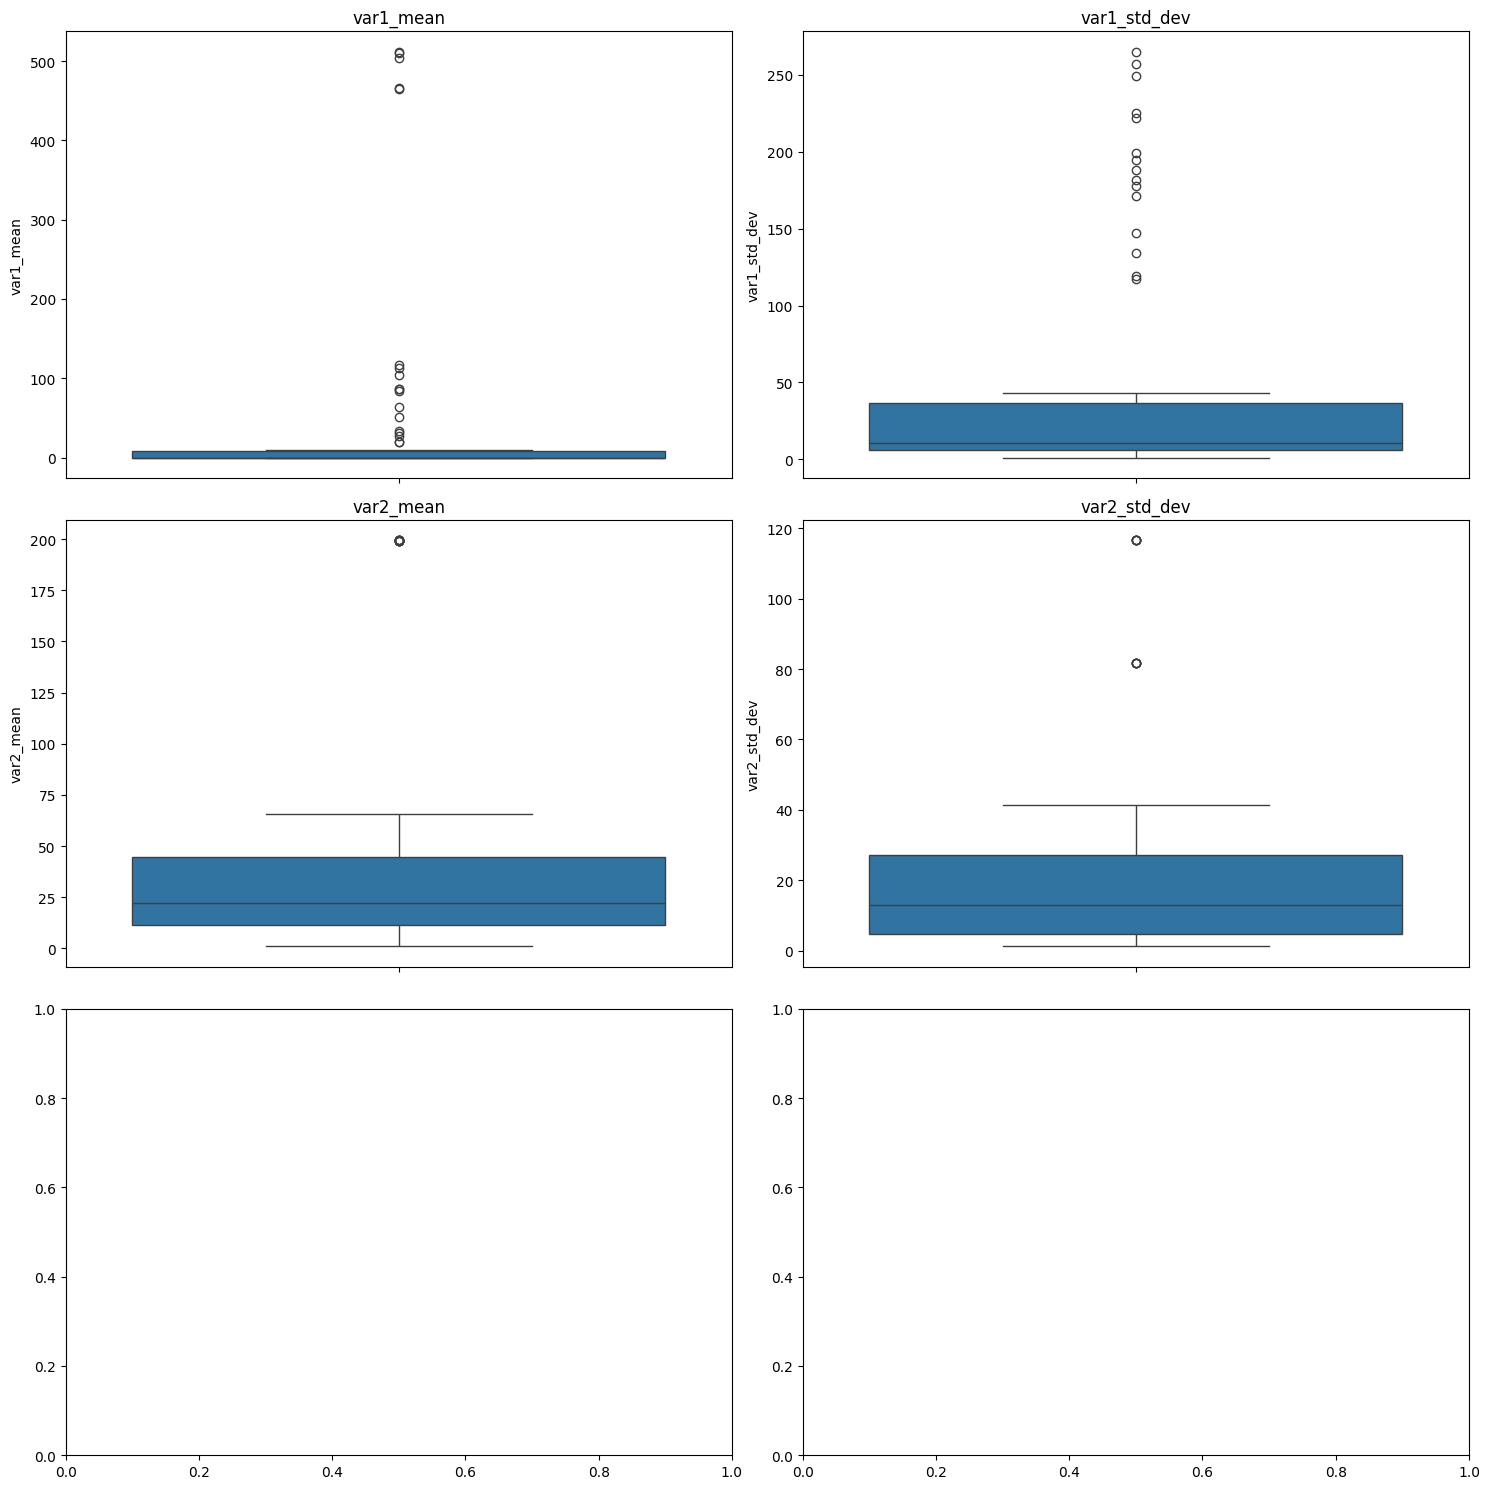

In [9]:
int_cols = data.select_dtypes(exclude='object').columns
num_plots = len(int_cols)
rows = 3  # Número de filas deseadas
cols = num_plots // rows + (num_plots % rows > 0)  # Número de columnas deseadas

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Ajusta el tamaño de la figura según tus necesidades

for i, col in enumerate(int_cols):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]  # Obtén el eje correspondiente
    sns.boxplot(data=data, y=col, ax=ax)
    ax.set_title(col)  # Opcional: establece el título de cada gráfico

plt.tight_layout()  # Ajusta el espaciado entre los gráficos
plt.show()

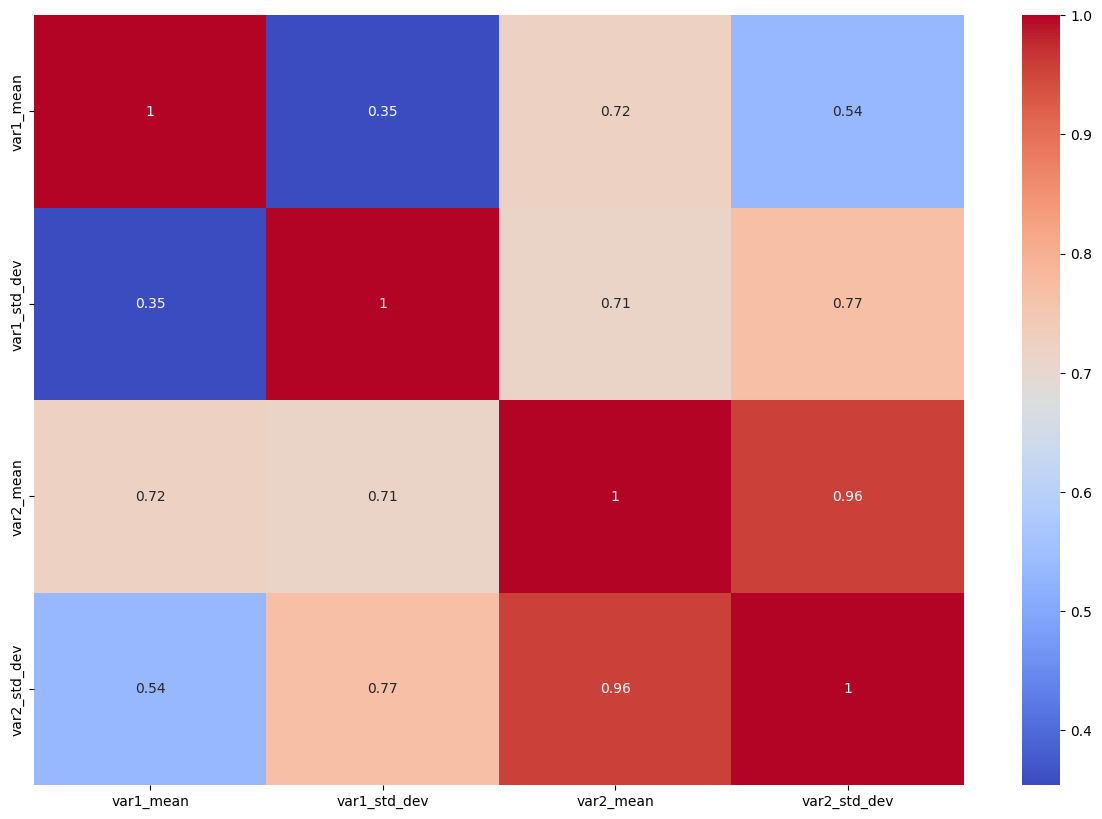

In [10]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(data.iloc[:,1:].corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Seleccionar todas las columnas numéricas para la estandarización
numeric_columns = data.select_dtypes(include=['float64']).columns

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])

# Convertir de nuevo a un DataFrame para mantener la consistencia
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)
# Añadir la columna 'type_building' de nuevo
data_scaled_df['type_building'] = data['type_building']

# Mostrar los primeros registros del DataFrame estandarizado
data_scaled_df.head()


,var1_mean,var1_std_dev,var2_mean,var2_std_dev,type_building
0,-0.349351,-0.555238,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
1,-0.349338,-0.550138,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
2,-0.349330,-0.542565,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
3,-0.349351,-0.576445,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
4,-0.349351,-0.574949,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004


In [12]:
# Separar las características numéricas
features = data_scaled_df.drop(columns=['type_building'])

In [13]:
features.head()

,var1_mean,var1_std_dev,var2_mean,var2_std_dev
0,-0.349351,-0.555238,-0.415152,-0.560958
1,-0.349338,-0.550138,-0.415152,-0.560958
2,-0.349330,-0.542565,-0.415152,-0.560958
3,-0.349351,-0.576445,-0.415152,-0.560958
4,-0.349351,-0.574949,-0.415152,-0.560958


## PCA

[3.09966332 0.68975104 0.24755345 0.0136651 ]


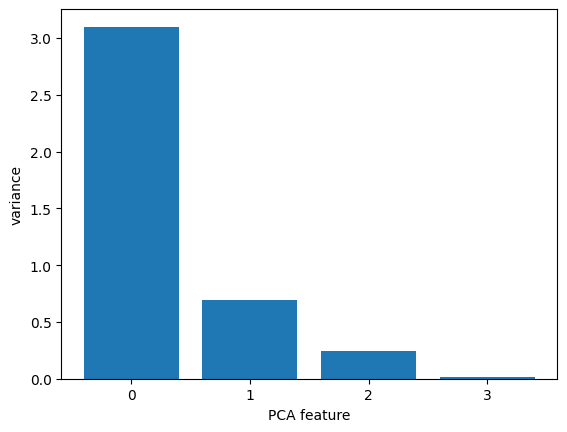

In [14]:
# Create a PCA instance: pca
pca = PCA()
# Fit the pipeline to 'samples'
pca.fit(features)
print(pca.explained_variance_)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

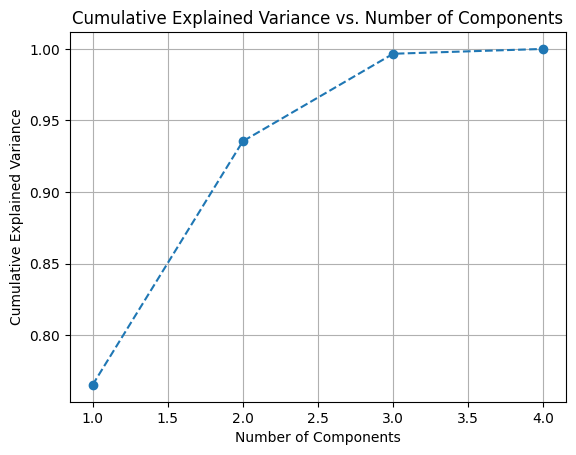

In [15]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [19]:
# Reducir la dimensionalidad utilizando PCA para seleccionar características no correlacionadas
# Separar las características numéricas
features = data_scaled_df.drop(columns=['type_building'])
pca = PCA(n_components=2)  # Seleccionamos un número razonable de componentes principales
principal_components = pca.fit_transform(features)

# Convertir a DataFrame para mantener la consistencia
principal_df =pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# # Añadir de nuevo la columna 'type_building'
# principal_df['type_building'] = data_reduced['type_building']

In [20]:
principal_df.head()

,PC1,PC2
0,-0.941967,0.118265
1,-0.939577,0.115390
2,-0.936032,0.111112
3,-0.951884,0.130264
4,-0.951185,0.129417


In [21]:
# Paso 1: Examinar las Componentes Principales (PCA)
pca_loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_loadings

,PC1,PC2
var1_mean,0.417030,0.795374
var1_std_dev,0.467641,-0.565804
var2_mean,0.559492,0.077132
var2_std_dev,0.542556,-0.203216


Las cargas de las componentes principales (PCA) indican qué variables originales tienen mayor influencia en cada componente. Aquí están algunas observaciones clave:



## CLUSTERING 

In [22]:
data_clustered=data.copy()
X=principal_df.copy()

### KMEANS

In [23]:
# Método del Codo para K-means
Sum_of_squared_distances = []
silhouette_scores = []
K_range = range(2, 11)
for _ in K_range:
    km = KMeans(n_clusters = _)
    y = km.fit_predict(X)
    Sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X,y))

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_13412\2047102112.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bx-" (-> marker='x'). The keyword argument will take precedence.
  ax[0].plot(K_range, Sum_of_squared_distances, 'bx-', marker='o')
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_13412\2047102112.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx-" (-> marker='x'). The keyword argument will take precedence.
  ax[1].plot(K_range, silhouette_scores, 'rx-', marker='o')


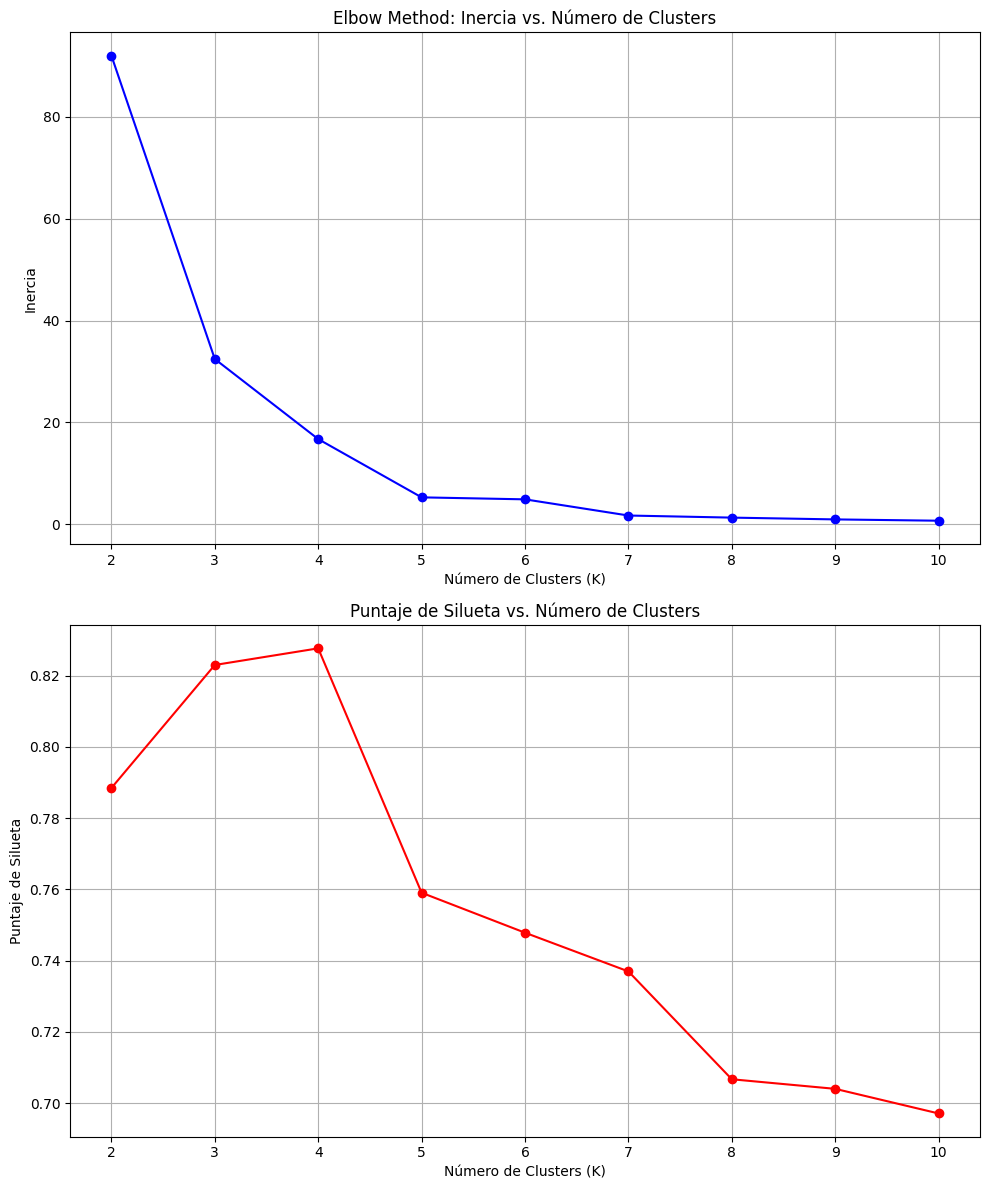

In [24]:
# Configurar las figuras y los subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de la suma de distancias cuadradas
ax[0].plot(K_range, Sum_of_squared_distances, 'bx-', marker='o')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inercia')
ax[0].set_title('Elbow Method: Inercia vs. Número de Clusters')
ax[0].grid(True)

# Gráfico del puntaje de silueta
ax[1].plot(K_range, silhouette_scores, 'rx-', marker='o')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Puntaje de Silueta')
ax[1].set_title('Puntaje de Silueta vs. Número de Clusters')
ax[1].grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [25]:
# Calcular las diferencias entre inercias
inertia_differences = [j - i for i, j in zip(Sum_of_squared_distances[:-1], Sum_of_squared_distances[1:])]
# Imprimir las diferencias entre inercias
for i, diff in enumerate(inertia_differences, start=2):
    print(f"Diferencia de inercia entre {i-1} y {i} clusters: {diff}")

Diferencia de inercia entre 1 y 2 clusters: -59.601369520987426
Diferencia de inercia entre 2 y 3 clusters: -15.729390926257746
Diferencia de inercia entre 3 y 4 clusters: -11.445932302379628
Diferencia de inercia entre 4 y 5 clusters: -0.3909837152132596
Diferencia de inercia entre 5 y 6 clusters: -3.1781167192177375
Diferencia de inercia entre 6 y 7 clusters: -0.4105783232504554
Diferencia de inercia entre 7 y 8 clusters: -0.3518216776260251
Diferencia de inercia entre 8 y 9 clusters: -0.2574433319480556


basandonos en la grafica de los cambios de inercia  utilizamos el metodo del codo para determinar el numero optimo de clusters a agrupar estan entre 2 a 3

In [26]:
# Aplicar K-means con un número de clusters razonable, por ejemplo, 3
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_KMeans'] = clusters_kmeans
# Mostrar los primeros registros con los clusters asignados
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [27]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_kmeans = silhouette_score(X, clusters_kmeans)
silhouette_kmeans

0.8276643604150067

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [28]:
# Calcular el índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, clusters_kmeans)
davies_bouldin

0.16485444634194846

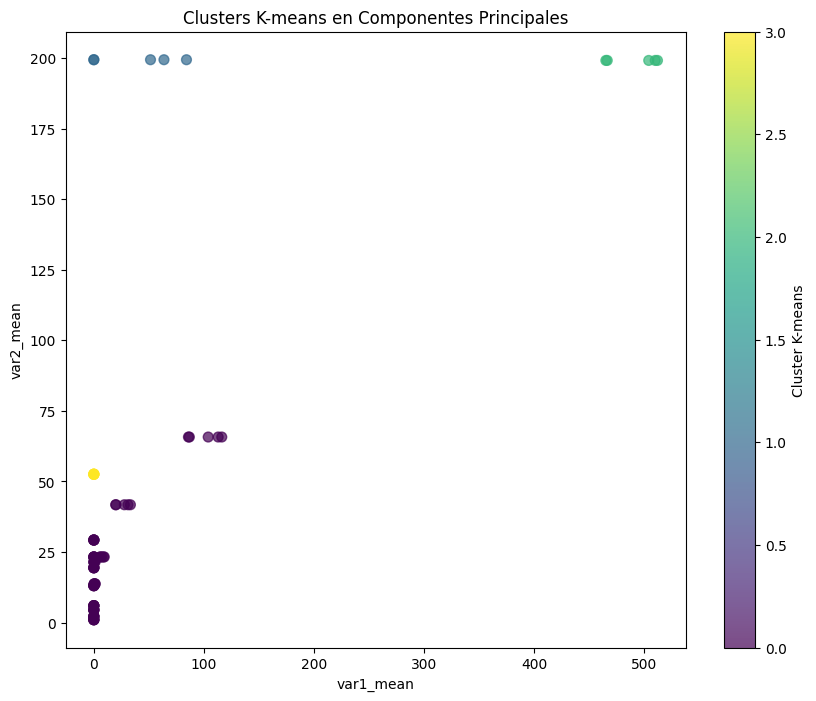

In [29]:
# Visualización de los clusters obtenidos por K-means
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered["var1_mean"], data_clustered['var2_mean'], c=data_clustered['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters K-means en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster K-means')
# Assign the cluster centers: centroids
# centroids = kmeans.cluster_centers_

# # Assign the columns of centroids: centroids_x, centroids_y
# centroids_x = centroids[:,0]
# centroids_y = centroids[:,1]

# # Make a scatter plot of centroids_x and centroids_y
# """
# scatter plot of centroids_x and centroids_y, using 'D' (a diamond) as a marker by specifying the marker parameter. Set the size of the markers to be 50 using s=50.
# """
# plt.scatter(centroids_x,centroids_y,marker="D",s=50)
plt.show()

In [30]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_KMeans'] )
# Display ct
ct

Cluster_KMeans,0,1,2,3
type_building,,,,
RefBldgFullServiceRestaurantNew2004,5,0,0,0
RefBldgHospitalNew2004,0,0,5,0
RefBldgLargeHotelNew2004,5,0,0,0
RefBldgLargeOfficeNew2004,0,5,0,0
RefBldgMediumOfficeNew2004,5,0,0,0
RefBldgMidriseApartmentNew2004,5,0,0,0
RefBldgOutPatientNew2004,5,0,0,0
RefBldgPrimarySchoolNew2004,5,0,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0,0


In [31]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_KMeans', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

KeyError: "['InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std'] not in index"

## DBSCAN

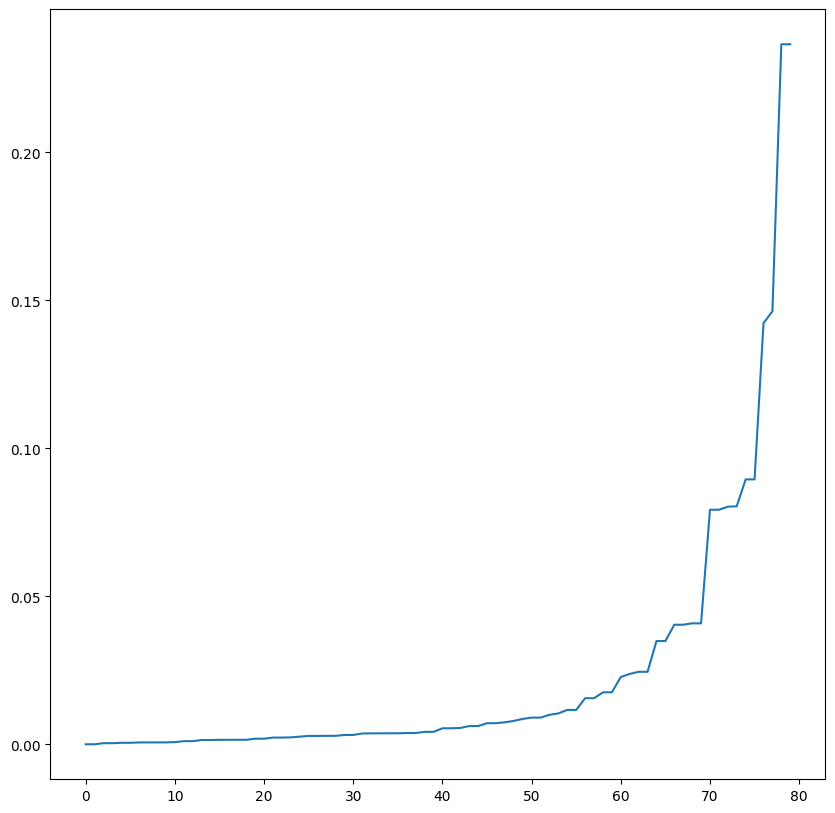

In [32]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = plt.figure(figsize=(10,10))
plt.plot(distances)

In [33]:
eps_values = np.arange(0.05, 0.20, 0.05)
min_samples = np.arange(3,12)

In [34]:
eps_values

array([0.05, 0.1 , 0.15, 0.2 ])

In [35]:
from itertools import product 
dbscan_paramns = list(product(eps_values,min_samples))
no_of_clusters = []
sil_score = []
for p in dbscan_paramns:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(X)
    try:
        sil_score.append(silhouette_score(X,y_dbscan))
    except:
        sil_score.append(0)    
    no_of_clusters.append(len(np.unique(y_dbscan)))

In [36]:
df_param_tunning = pd.DataFrame.from_records(dbscan_paramns, columns=['Eps','Min_samples'])
df_param_tunning['sil_score'] = sil_score
df_param_tunning['n_clusters'] = no_of_clusters

In [37]:
pivot_1 = pd.pivot_table(df_param_tunning, values='sil_score', columns='Eps', index='Min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='n_clusters', columns='Eps', index='Min_samples')

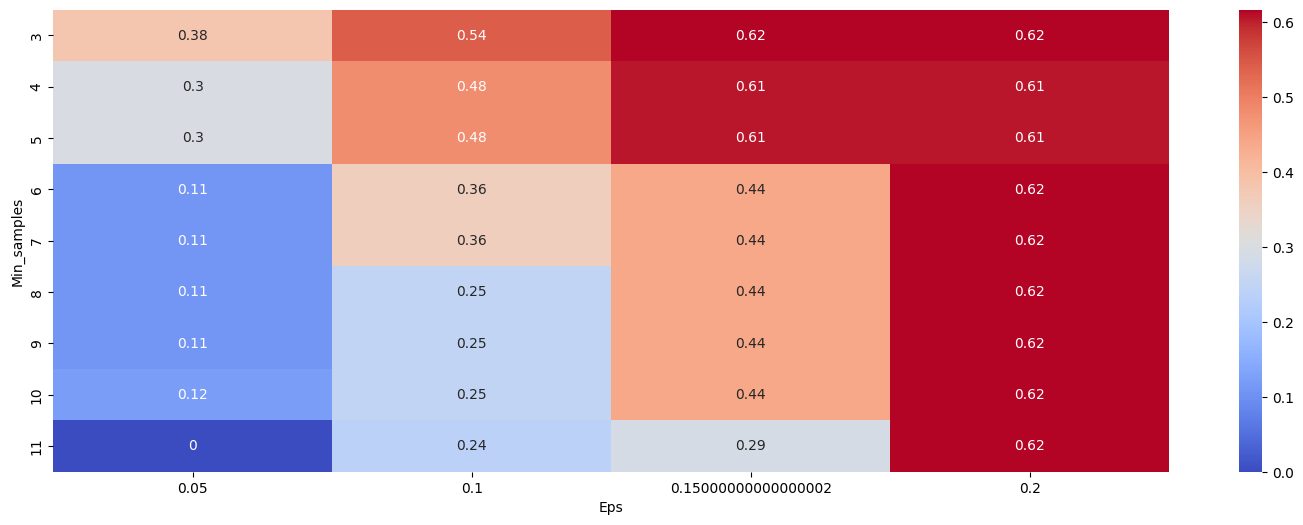

In [38]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

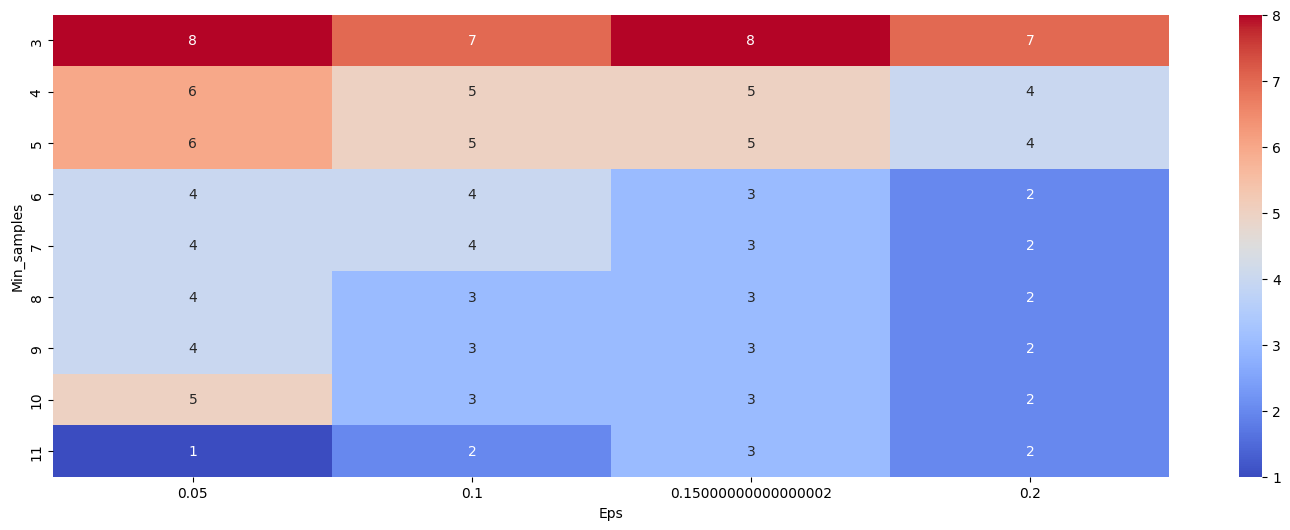

In [39]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

In [41]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_DBSCAN'] = clusters_dbscan
# Mostrar los primeros registros con los clusters asignados por DBSCAN
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans,Cluster_DBSCAN
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [42]:
# Calcular el silhouette score para evaluar la calidad de los clusters, excluyendo los puntos ruidosos
if len(set(clusters_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(X, clusters_dbscan)
else:
    silhouette_dbscan = -1  # Silhouette score no es aplicable si hay un solo cluster
silhouette_dbscan

0.6064317977574729

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [43]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_dbscan= davies_bouldin_score(X, clusters_dbscan)
davies_bouldin_dbscan

0.6707575003775589

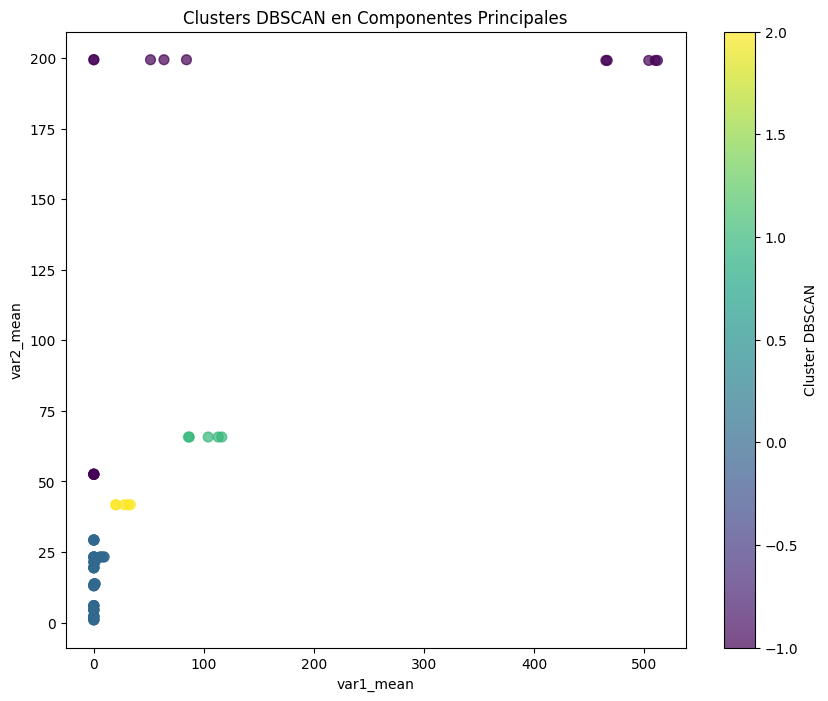

In [44]:
# Visualización de los clusters obtenidos por DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered['var1_mean'], data_clustered['var2_mean'], c=data_clustered['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster DBSCAN')
plt.show()

In [45]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_DBSCAN'] )
# Display ct
ct

Cluster_DBSCAN,-1,0,1,2
type_building,,,,
RefBldgFullServiceRestaurantNew2004,0,5,0,0
RefBldgHospitalNew2004,5,0,0,0
RefBldgLargeHotelNew2004,0,0,5,0
RefBldgLargeOfficeNew2004,5,0,0,0
RefBldgMediumOfficeNew2004,0,5,0,0
RefBldgMidriseApartmentNew2004,0,5,0,0
RefBldgOutPatientNew2004,0,0,0,5
RefBldgPrimarySchoolNew2004,0,5,0,0
RefBldgQuickServiceRestaurantNew2004,0,5,0,0


In [46]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

for var in features:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=features, x=data_clustered['Cluster_DBSCAN'], y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

KeyError: "['InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std'] not in index"

## CLUSTERING HERARQUICO 

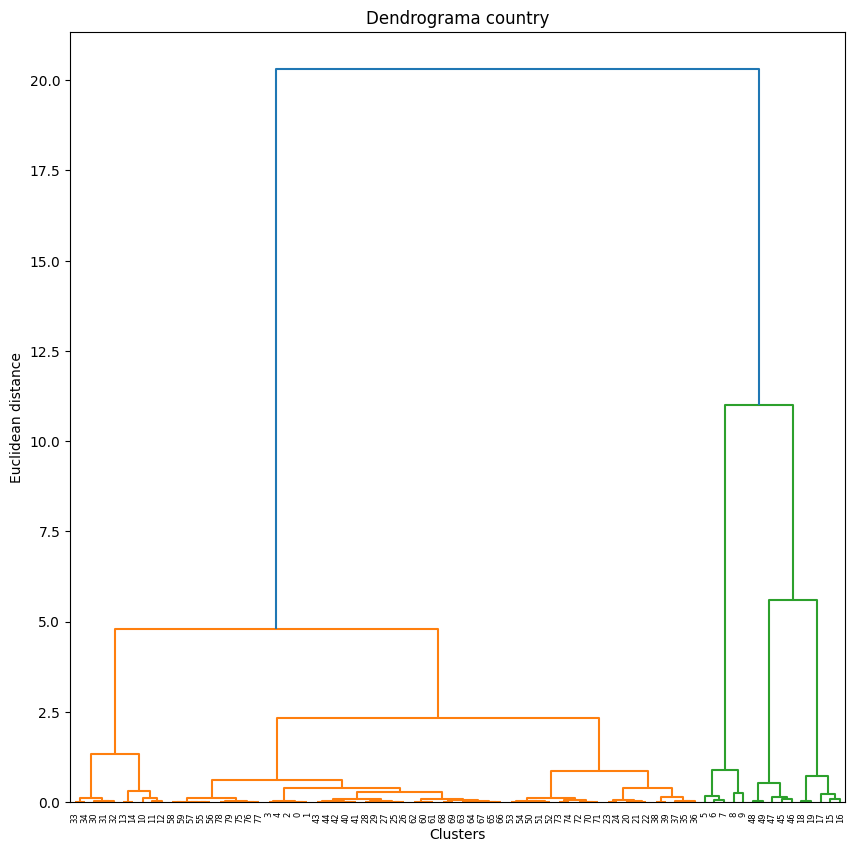

In [47]:
fig = plt.figure(figsize=(10,10))
dendrogram_plot = dendrogram(linkage(X, method='ward'))
plt.title('Dendrograma country')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distance')
plt.show()

In [48]:
# Calcular el linkage matrix
mergings = linkage(X, method='ward')

# Calcular las alturas de los clusters
last = mergings[-10:, 2]
last_rev = last[::-1]
indexes = np.arange(1, len(last) + 1)

# Calcular la aceleración
acceleration = np.diff(last, 2)  # Segunda derivada de las alturas
acceleration_rev = acceleration[::-1]

# Encontrar el número óptimo de clusters
k = acceleration_rev.argmax() + 2  # +2 porque la primera derivada se pierde y Python indexa desde 0

print(f'El número óptimo de clusters es: {k}')

El número óptimo de clusters es: 3


In [50]:
# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=3)
clusters_hierarchical = hierarchical.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_Hierarchical'] = clusters_hierarchical
# Mostrar los primeros registros con los clusters asignados por Clustering Jerárquico
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans,Cluster_DBSCAN,Cluster_Hierarchical
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0,0,1
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0,0,1
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0,0,1
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0,0,1
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0,0,1


In [51]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import AgglomerativeClustering
# from scipy.spatial.distance import cdist
# # Calcular el centroide de cada clúster
# centroids = principal_df.groupby('Cluster_Hierarchical').mean().iloc[:, :3].values

# # Encontrar el punto más cercano al centroide en cada clúster
# closest_points = []

# for cluster_id in range(2):
#     cluster_points = principal_df[principal_df['Cluster_Hierarchical'] == cluster_id].iloc[:, :3].values
#     centroid = centroids[cluster_id].reshape(1, -1)
    
#     # Calcular la distancia euclidiana de cada punto al centroide
#     distances = cdist(cluster_points, centroid, metric='euclidean')
    
#     # Encontrar el índice del punto más cercano al centroide
#     closest_point_idx = np.argmin(distances)
    
#     # Obtener el índice original en el DataFrame
#     original_idx = principal_df[principal_df['Cluster_Hierarchical'] == cluster_id].index[closest_point_idx]
#     closest_points.append(original_idx)

# # Mostrar los puntos más cercanos a los centroides
# closest_points_data = principal_df.loc[closest_points]


In [52]:
# closest_points_data.to_csv("../data/interim/closest_points.csv")

**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [53]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(X, clusters_hierarchical)
silhouette_hierarchical

0.8229940387655053

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [54]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_hierarchical= davies_bouldin_score(X, clusters_hierarchical)
davies_bouldin_hierarchical

0.4029661514722774

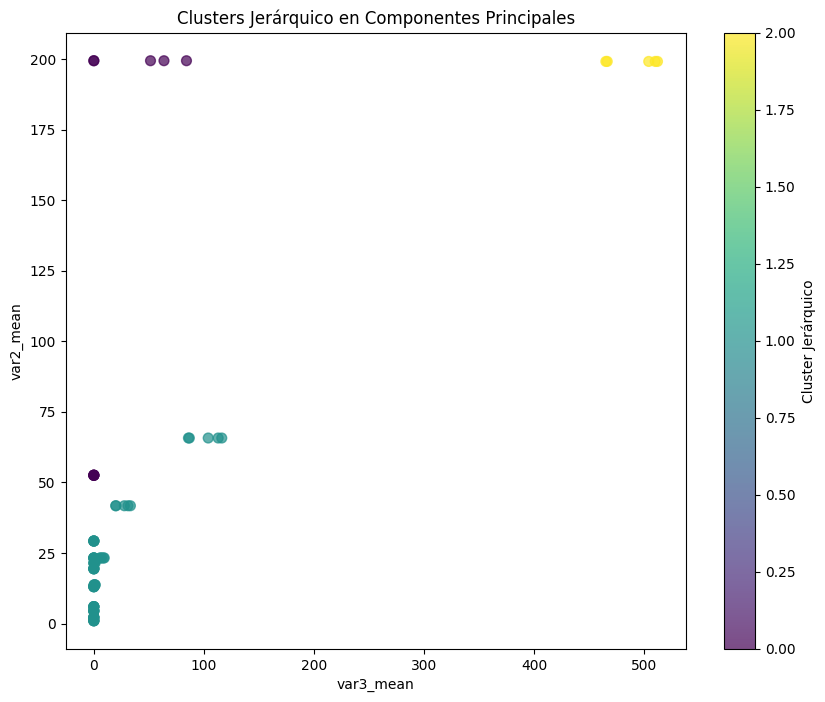

In [56]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered["var1_mean"], data_clustered['var2_mean'], c=data_clustered['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('var3_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster Jerárquico')
plt.show()

In [89]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_Hierarchical'] )
# Display ct
ct

Cluster_Hierarchical,0,1,2
type_building,,,
RefBldgFullServiceRestaurantNew2004,0,5,0
RefBldgHospitalNew2004,0,0,5
RefBldgLargeHotelNew2004,0,5,0
RefBldgLargeOfficeNew2004,5,0,0
RefBldgMediumOfficeNew2004,0,5,0
RefBldgMidriseApartmentNew2004,0,5,0
RefBldgOutPatientNew2004,0,5,0
RefBldgPrimarySchoolNew2004,0,5,0
RefBldgQuickServiceRestaurantNew2004,0,5,0


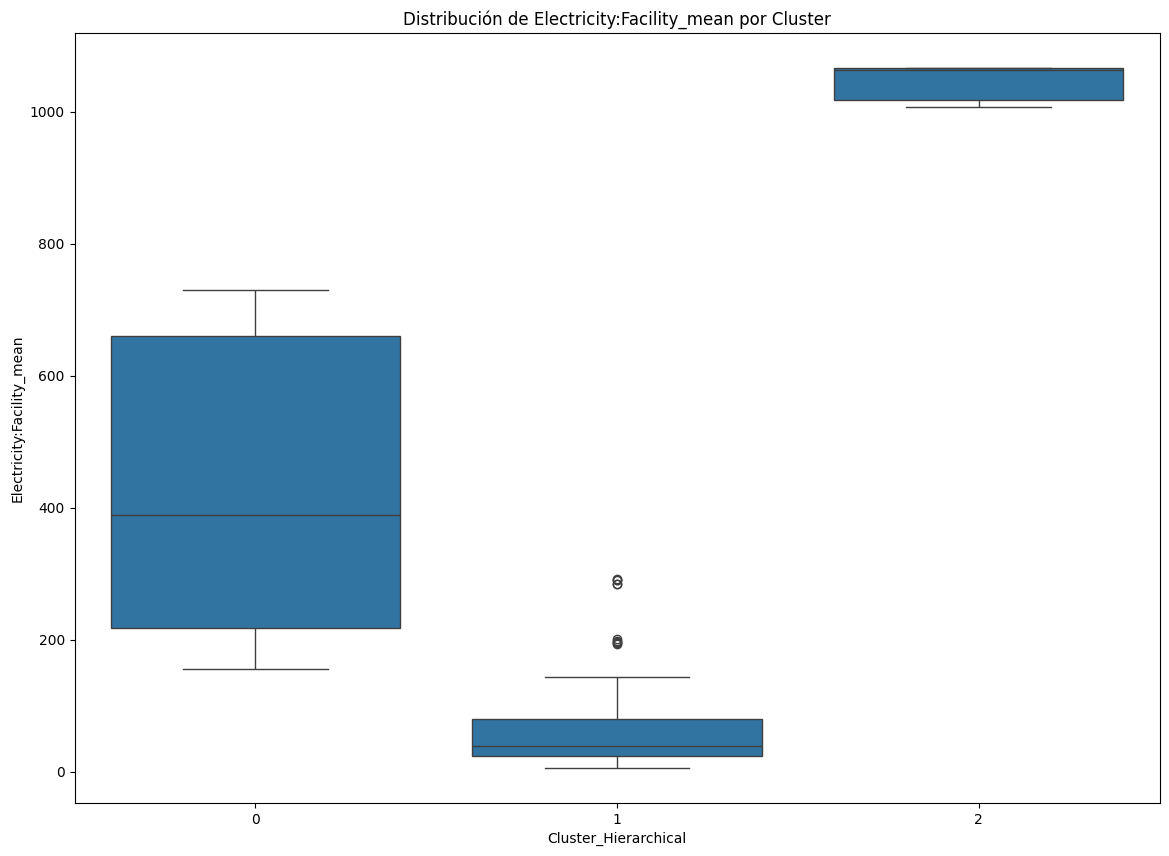

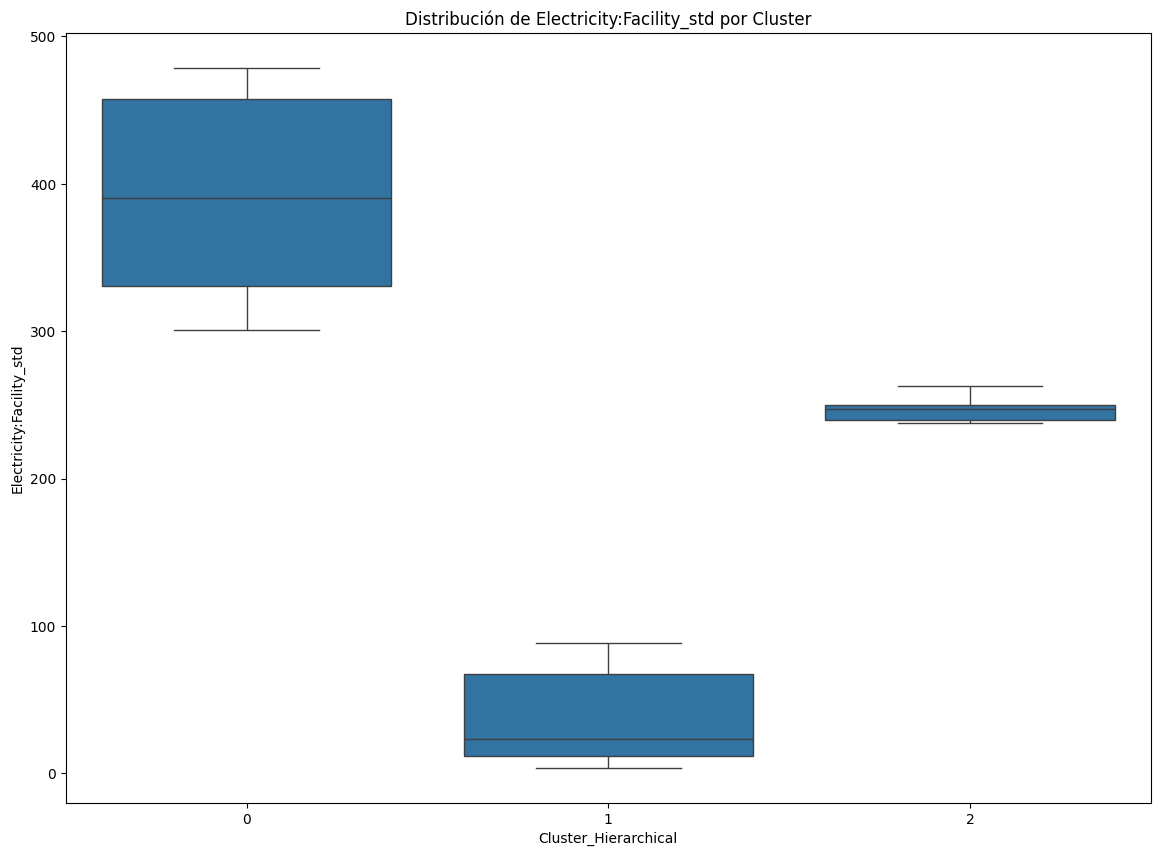

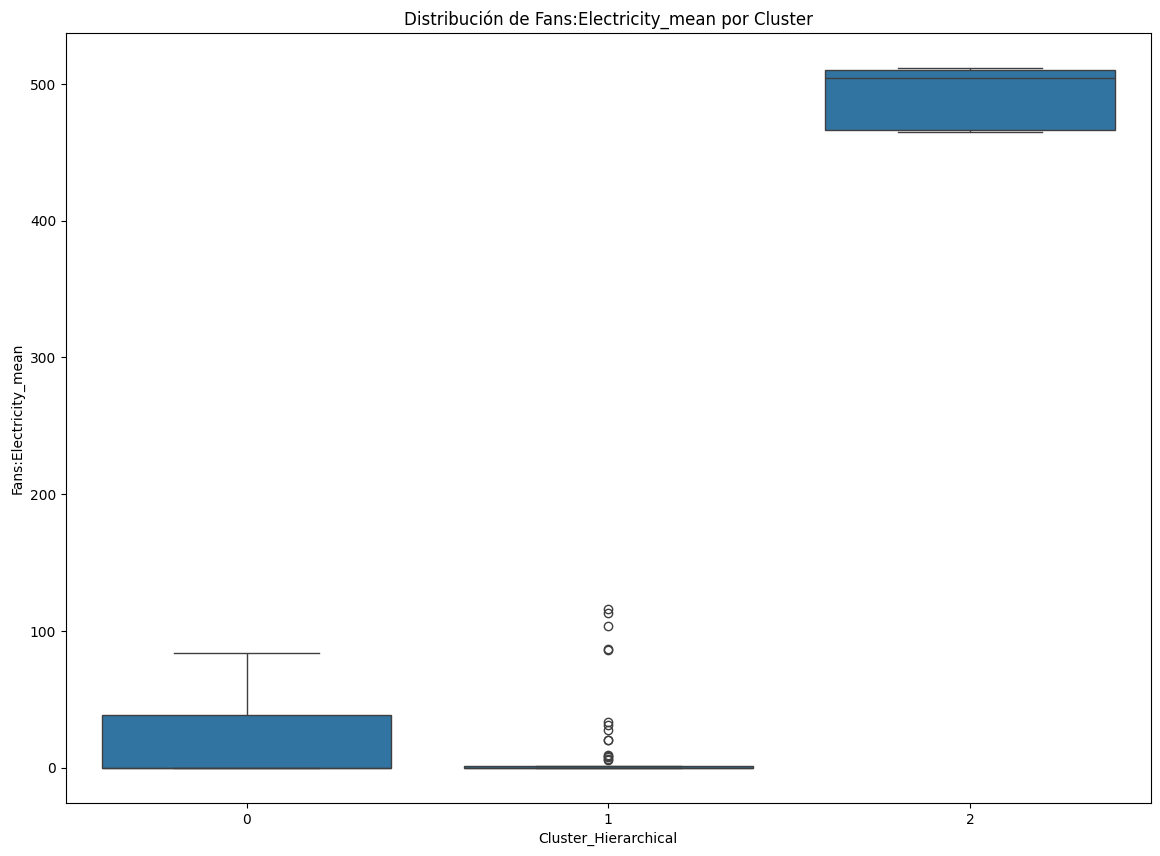

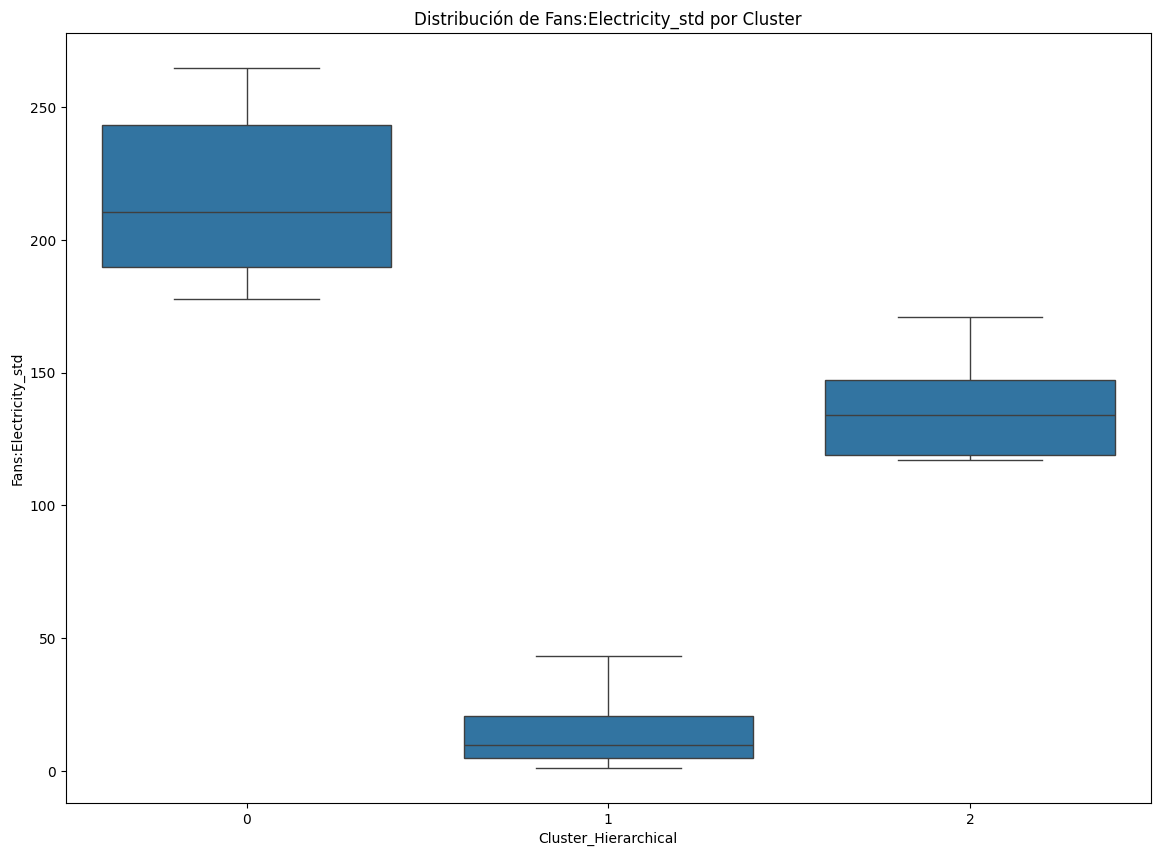

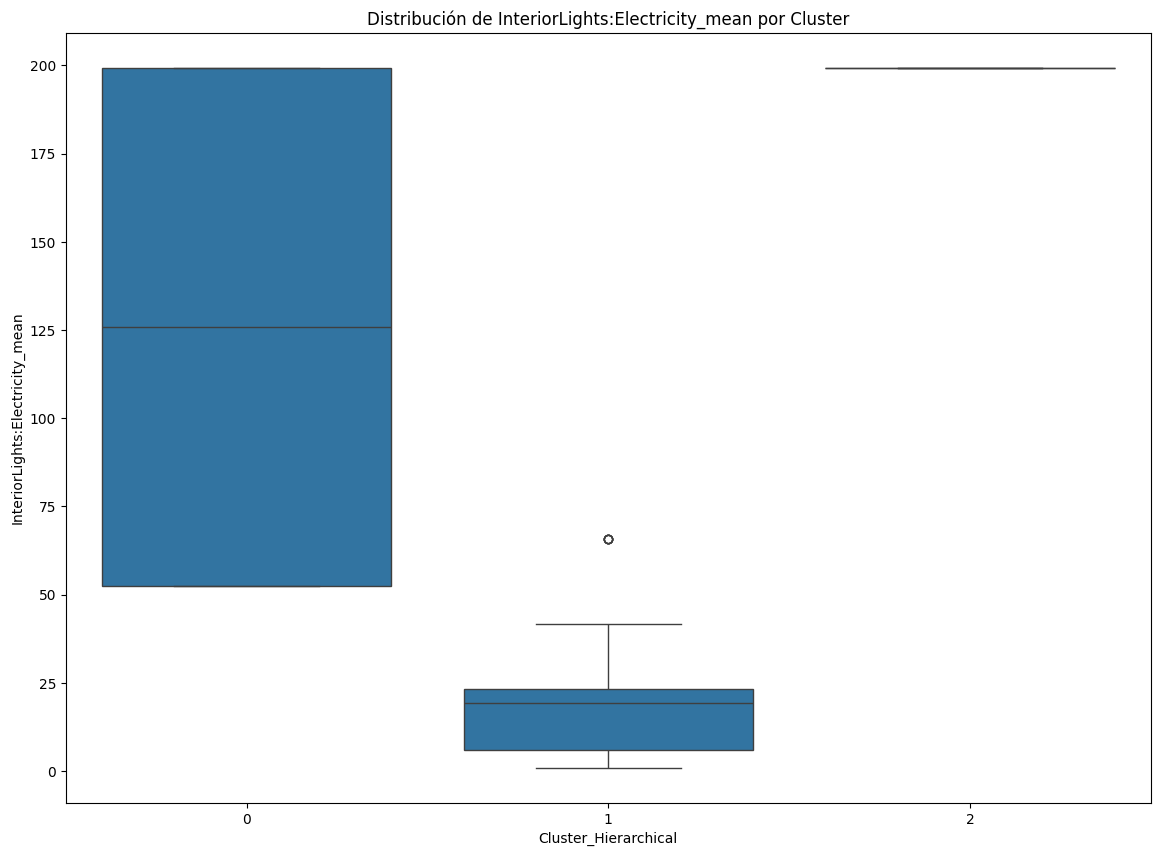

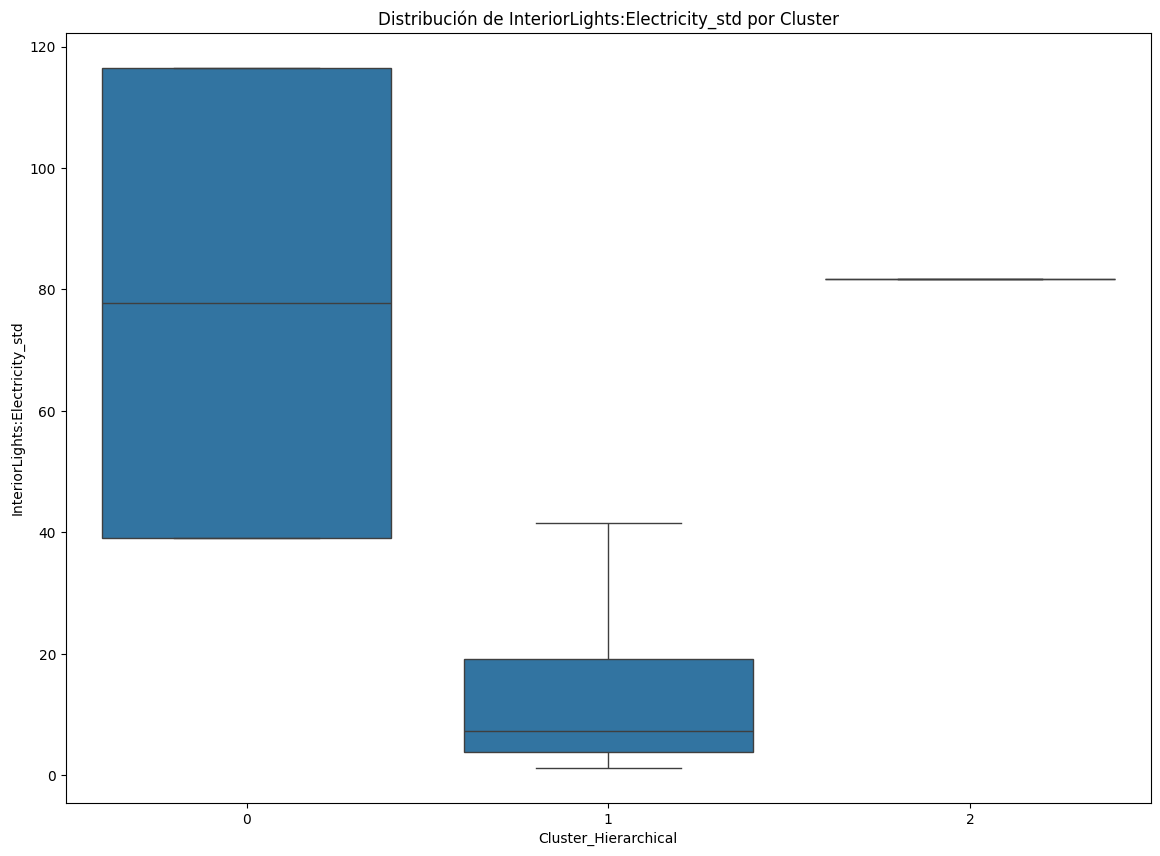

In [90]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]


for var in features:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=features, x=data_clustered['Cluster_Hierarchical'], y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.savefig(f'{var}_boxplot.png')
    plt.show()

In [85]:
# data_scaled_df.to_csv("../data/interim/clustering_pca.csv")

## Gaussian Mixture 

In [57]:
from sklearn.mixture import GaussianMixture

Text(0.5, 0, 'Number Of Component')

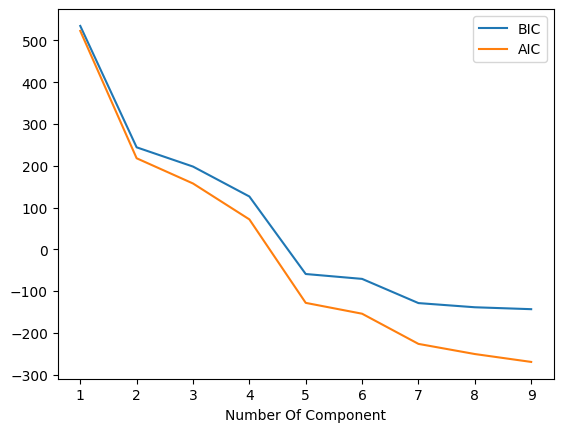

In [59]:
#Prepare
n_conponent = np.arange(1,10)

#Create GGM Model
models = [GaussianMixture(n_components = n,
                          random_state=42).fit(X) for n in n_conponent]
#Plot
plt.plot(n_conponent,
         [m.bic(X) for m in models],
         label = 'BIC')
plt.plot(n_conponent,
         [m.aic(X) for m in models],
         label = 'AIC')
plt.legend()
plt.xlabel("Number Of Component")

In [60]:
# create GM Models
model = GaussianMixture(n_components=5,
                        random_state=42).fit(X)
cluster = pd.Series(model.predict(X))
data_clustered['cluster_GMM'] = cluster
data_clustered

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans,Cluster_DBSCAN,Cluster_Hierarchical,cluster_GMM
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0,0,1,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0,0,1,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0,0,1,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0,0,1,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0,0,1,0
...,...,...,...,...,...,...,...,...,...
75,RefBldgWarehouseNew2004,0.000000,3.543234,1.0116,3.418924,0,0,1,0
76,RefBldgWarehouseNew2004,0.000000,3.778460,1.0116,3.418924,0,0,1,0
77,RefBldgWarehouseNew2004,0.000000,3.968506,1.0116,3.418924,0,0,1,0
78,RefBldgWarehouseNew2004,0.000000,2.526466,1.0116,3.418924,0,0,1,0


In [62]:
data_clustered.cluster_GMM.value_counts()

cluster_GMM
0    65
2     5
1     5
3     5
Name: count, dtype: int64

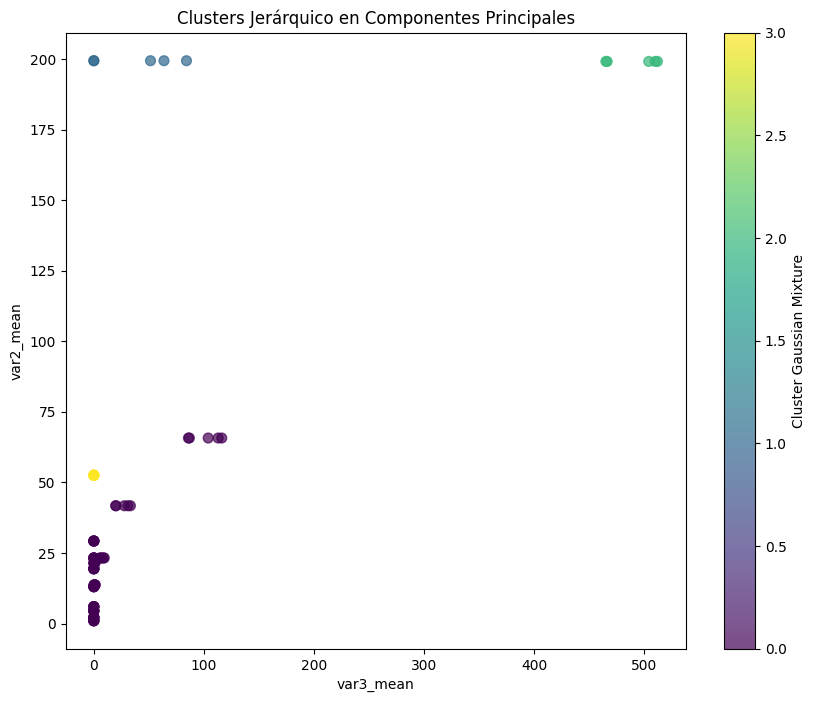

In [63]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered["var1_mean"], data_clustered['var2_mean'], c=data_clustered['cluster_GMM'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('var3_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster Gaussian Mixture')
plt.show()

In [64]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['cluster_GMM'] )
# Display ct
ct

cluster_GMM,0,1,2,3
type_building,,,,
RefBldgFullServiceRestaurantNew2004,5,0,0,0
RefBldgHospitalNew2004,0,0,5,0
RefBldgLargeHotelNew2004,5,0,0,0
RefBldgLargeOfficeNew2004,0,5,0,0
RefBldgMediumOfficeNew2004,5,0,0,0
RefBldgMidriseApartmentNew2004,5,0,0,0
RefBldgOutPatientNew2004,5,0,0,0
RefBldgPrimarySchoolNew2004,5,0,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0,0
